### Imports

In [2]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set()

import warnings
warnings.filterwarnings("ignore")

c:\Users\SHUBHAM\anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data extraction and Preprocessing

In [3]:
# with open("./lists/country_names_a_m.pkl", "rb") as f:
#     a_m = pickle.load(f)

# with open("./lists/country_names_n_z.pkl", "rb") as f:
#     n_z = pickle.load(f)

# with open("./lists/country_names_a_z.pkl", "rb") as f:
#     country_names = pickle.load(f)

with open("./lists/commodities.pkl", "rb") as f:
    commodities = pickle.load(f)

In [4]:
commodities_name = list(commodities.values())
dfs = pd.read_excel("./data/commodity_wise_data.xlsx", sheet_name=commodities_name)

dfs = dict(zip(list(commodities.keys()), list(dfs.values())))
len(dfs)

20

In [5]:
# change index to country names
for k, df in dfs.items():
    dfs[k].index = df.iloc[:, 0].values
    dfs[k].drop(df.columns[0], axis=1, inplace=True)

In [5]:
"""MinMaxScaling"""
# using minmaxscaling coz it retains the distribution of the data and scales the data to a fixed range [0,1]
# rescale it to [0,100] whih is easier to interpret. Also because the data is scattered

# update
# not using minmaxscaling because it is not good for scattered data
# shifts the data to a very narrow range [0,1] and the data becomes even more scattered
# from sklearn.preprocessing import MinMaxScaler
# minmax_scaler = MinMaxScaler()


"""power transform dfs"""



"""Log with drift"""
# taking log with drift after minmaxscaling shifts the data towards the mean
# doesnt solve the label skewness problem

# however with minmax scaling it seems it work??

'Log with drift'

In [6]:
dfs[2]

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Afghanistan,0,0,0,0,0,0,0,0,176592,157494,...,0,0,0,120515,200173,59590,57799,55781,0,0
Albania,191976,265527,470798,618993,553144,590927,148193,2417036,3922028,2207123,...,5157600,1164077,1965,1358021,1081040,1145677,359739,129845,591253,0
Algeria,1514,0,409870,5713102,5679682,5457447,3984677,2014541,2962553,2274893,...,2253969,4862264,4082413,2603922,408134,731736,0,0,0,0
Andorra,138,0,5711,0,15828,4847,35557,11561,3852,1721,...,2644,6088,219,29698,15144,9461,0,0,0,0
Angola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1189393,320612,97049,332761,1606096,698716,150294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Viet Nam,82917000,193876784,89700403,70567731,37252936,87935033,92932951,20009707,34363407,29112313,...,127205873,119393963,99931027,101200506,75246667,66734782,95882164,92154228,98565370,111844190
Yemen,0,6252454,4721309,4895077,7332032,10400861,10477902,15523575,23563016,14395564,...,24162081,29765103,33850269,17994960,0,0,0,1318,0,0
Zambia,4587290,4308452,2532782,1774978,791334,8321510,2006844,11210073,2893987,15490712,...,6784390,3980069,6319639,761139,252180,633454,194653,3557097,13702818,40566830
Zimbabwe,12579820,1644649,14937407,13054672,30216119,9438668,8683430,20801051,3503923,4151168,...,3747760,2137087,960321,761139,252180,633454,194653,3557097,3933558,3703617


In [7]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

# function to transform data
def transform(df_dict, transformation, **params):
    dfs_t = dict()
    if transformation == "None":
        str = "No transformation"
        dfs_t = df_dict.copy()
    if transformation == "MinMaxScaler":
        str = "MinMax scaling"
        for k, df in df_dict.items():
            minmax_scaler = MinMaxScaler()
            dfs_t[k] = pd.DataFrame(minmax_scaler.fit_transform(df), columns=df.columns, index=df.index)
            dfs_t[k] *= 100
    if transformation == "PowerTransformer":
        str = "Power transformation with method {} and standardize {}".format(params['method'], params['standardize'])
        for k, df in df_dict.items():
            pt = PowerTransformer(method=params['method'], standardize=params['standardize'])
            dfs_t[k] = pd.DataFrame(pt.fit_transform(df), columns=df.columns, index=df.index)
    if transformation == "Log":
        str = "Log transformation with drift {}".format(params['e'])
        for k, df in df_dict.items():
            dfs_t[k] = np.log(df + params['e'])

    return dfs_t, str

# plotting all commodities
def plot_all_commodity(df_dict, transformation):
    fig, ax = plt.subplots(5, 4, figsize=(18, 18))
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    if transformation:
        fig.suptitle(transformation, fontsize=24, color='red')

    ax = ax.flatten()
    for i, (k, df) in enumerate(df_dict.items()):
        ax[i].hist(df.values.flatten(), bins=100)
        ax[i].set_title("Commodity {}".format(k))

    plt.show()


# plot one commidity with different all transformations
def plot_one_commodity_with_transformation(df_dict, commodity):
    fig, ax = plt.subplots(4, 2, figsize=(18, 18))
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.suptitle(commodities[commodity], fontsize=24, color='red')

    tdf = dict()
    tdf[commodity] = df_dict[commodity].copy()

    tdf_1, str_1 = transform(tdf, "None")
    tdf_2, str_2 = transform(tdf, "MinMaxScaler")
    tdf_3, str_3 = transform(tdf, "PowerTransformer", method='yeo-johnson', standardize=False)
    tdf_4, str_4 = transform(tdf, "Log", e=1)

    ax[0, 0].set_title(str_1)
    ax[0, 1].set_title(str_1)
    ax[1, 0].set_title(str_2)
    ax[1, 1].set_title(str_2)
    ax[2, 0].set_title(str_3)
    ax[2, 1].set_title(str_3)
    ax[3, 0].set_title(str_4)
    ax[3, 1].set_title(str_4)

    df_1 = tdf_1[commodity].copy()
    df.plot(kind='hist', ax=ax[0, 0], alpha=0.5, legend=False)

    df.plot(kind='kde', ax=ax[0, 1], alpha=0.5, legend=False)

    df_2 = tdf_2[commodity].copy()
    df_2.plot(kind='hist', ax=ax[1, 0], alpha=0.5, legend=False)
    df_2.plot(kind='kde', ax=ax[1, 1], alpha=0.5, legend=False)

    df_3 = tdf_3[commodity].copy()
    df_3.plot(kind='hist', ax=ax[2, 0], alpha=0.5, legend=False)
    df_3.plot(kind='kde', ax=ax[2, 1], alpha=0.5, legend=False)

    df_4 = tdf_4[commodity].copy()
    df_4.plot(kind='hist', ax=ax[3, 0], alpha=0.5, legend=False)
    df_4.plot(kind='kde', ax=ax[3, 1], alpha=0.5, legend=False)

    handles, labels = ax[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    plt.subplots_adjust(right=0.9)
    
    plt.show()

# ploting single commodity for all countries
def plot_one_commodity(df_dict, commodity, transformation, kind):
    df_dict[commodity].plot(kind=kind, figsize=(18, 8), alpha=0.5)
    plt.title("Commodity {} {}".format(commodities[commodity], transformation))
    plt.show()

#### Grid of plots with various transformations

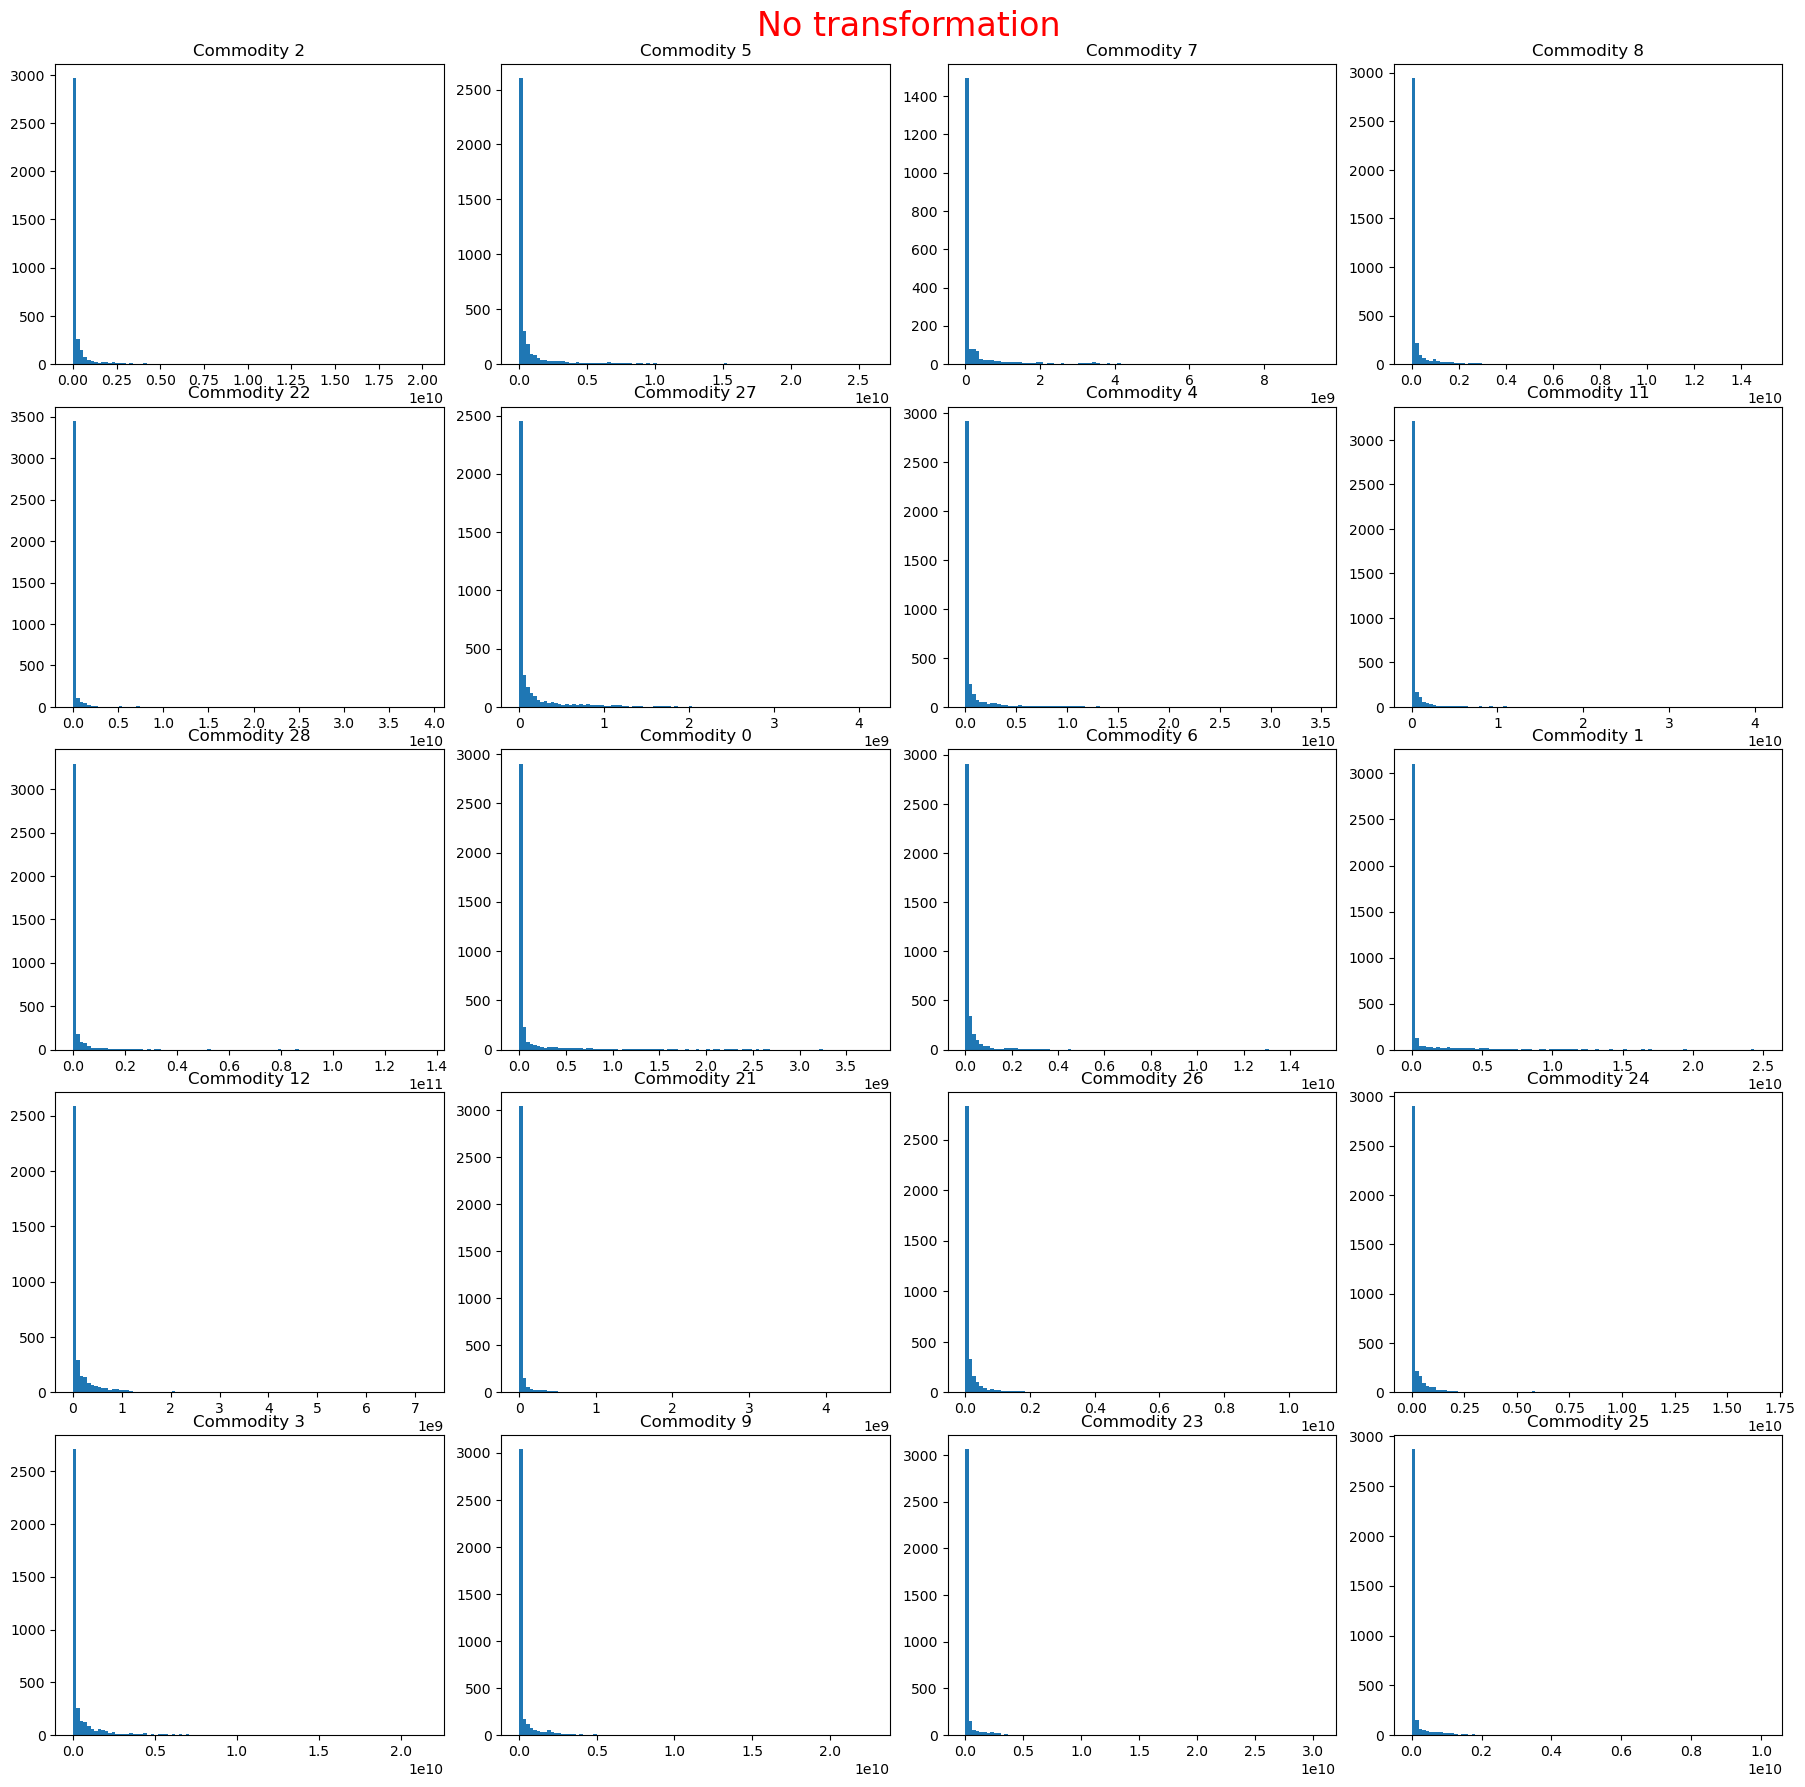

In [8]:
dfs_t, title = transform(dfs, transformation="None")
plot_all_commodity(dfs, transformation=title)

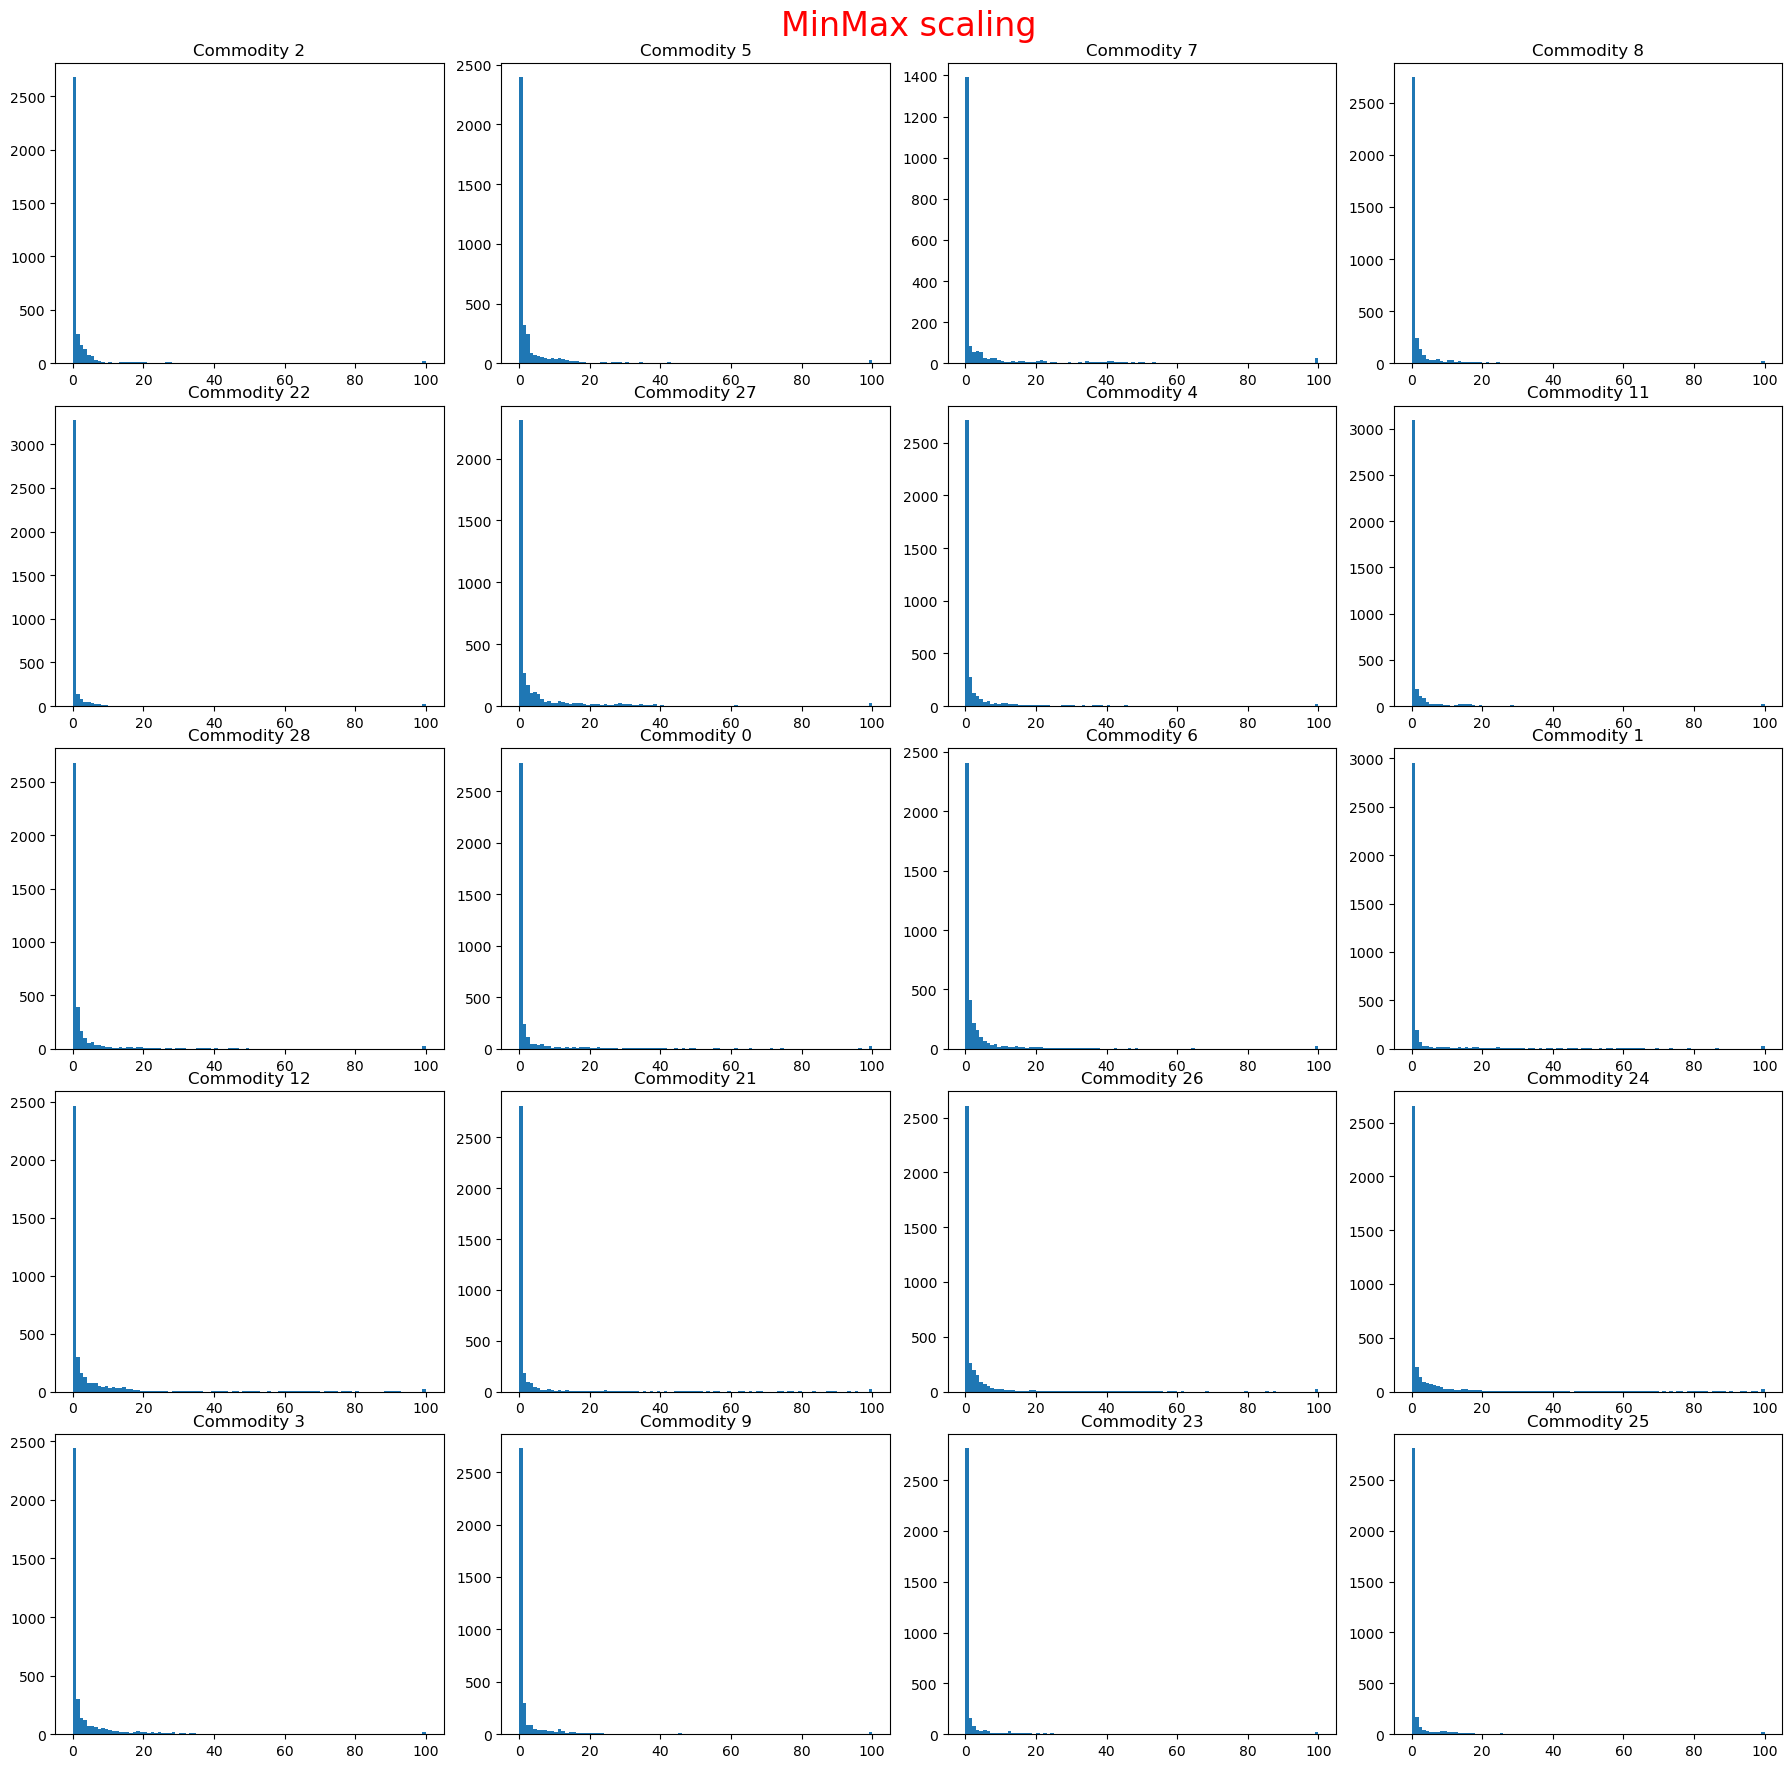

In [9]:
dfs_mm, title = transform(dfs, "MinMaxScaler")
plot_all_commodity(dfs_mm, transformation=title)

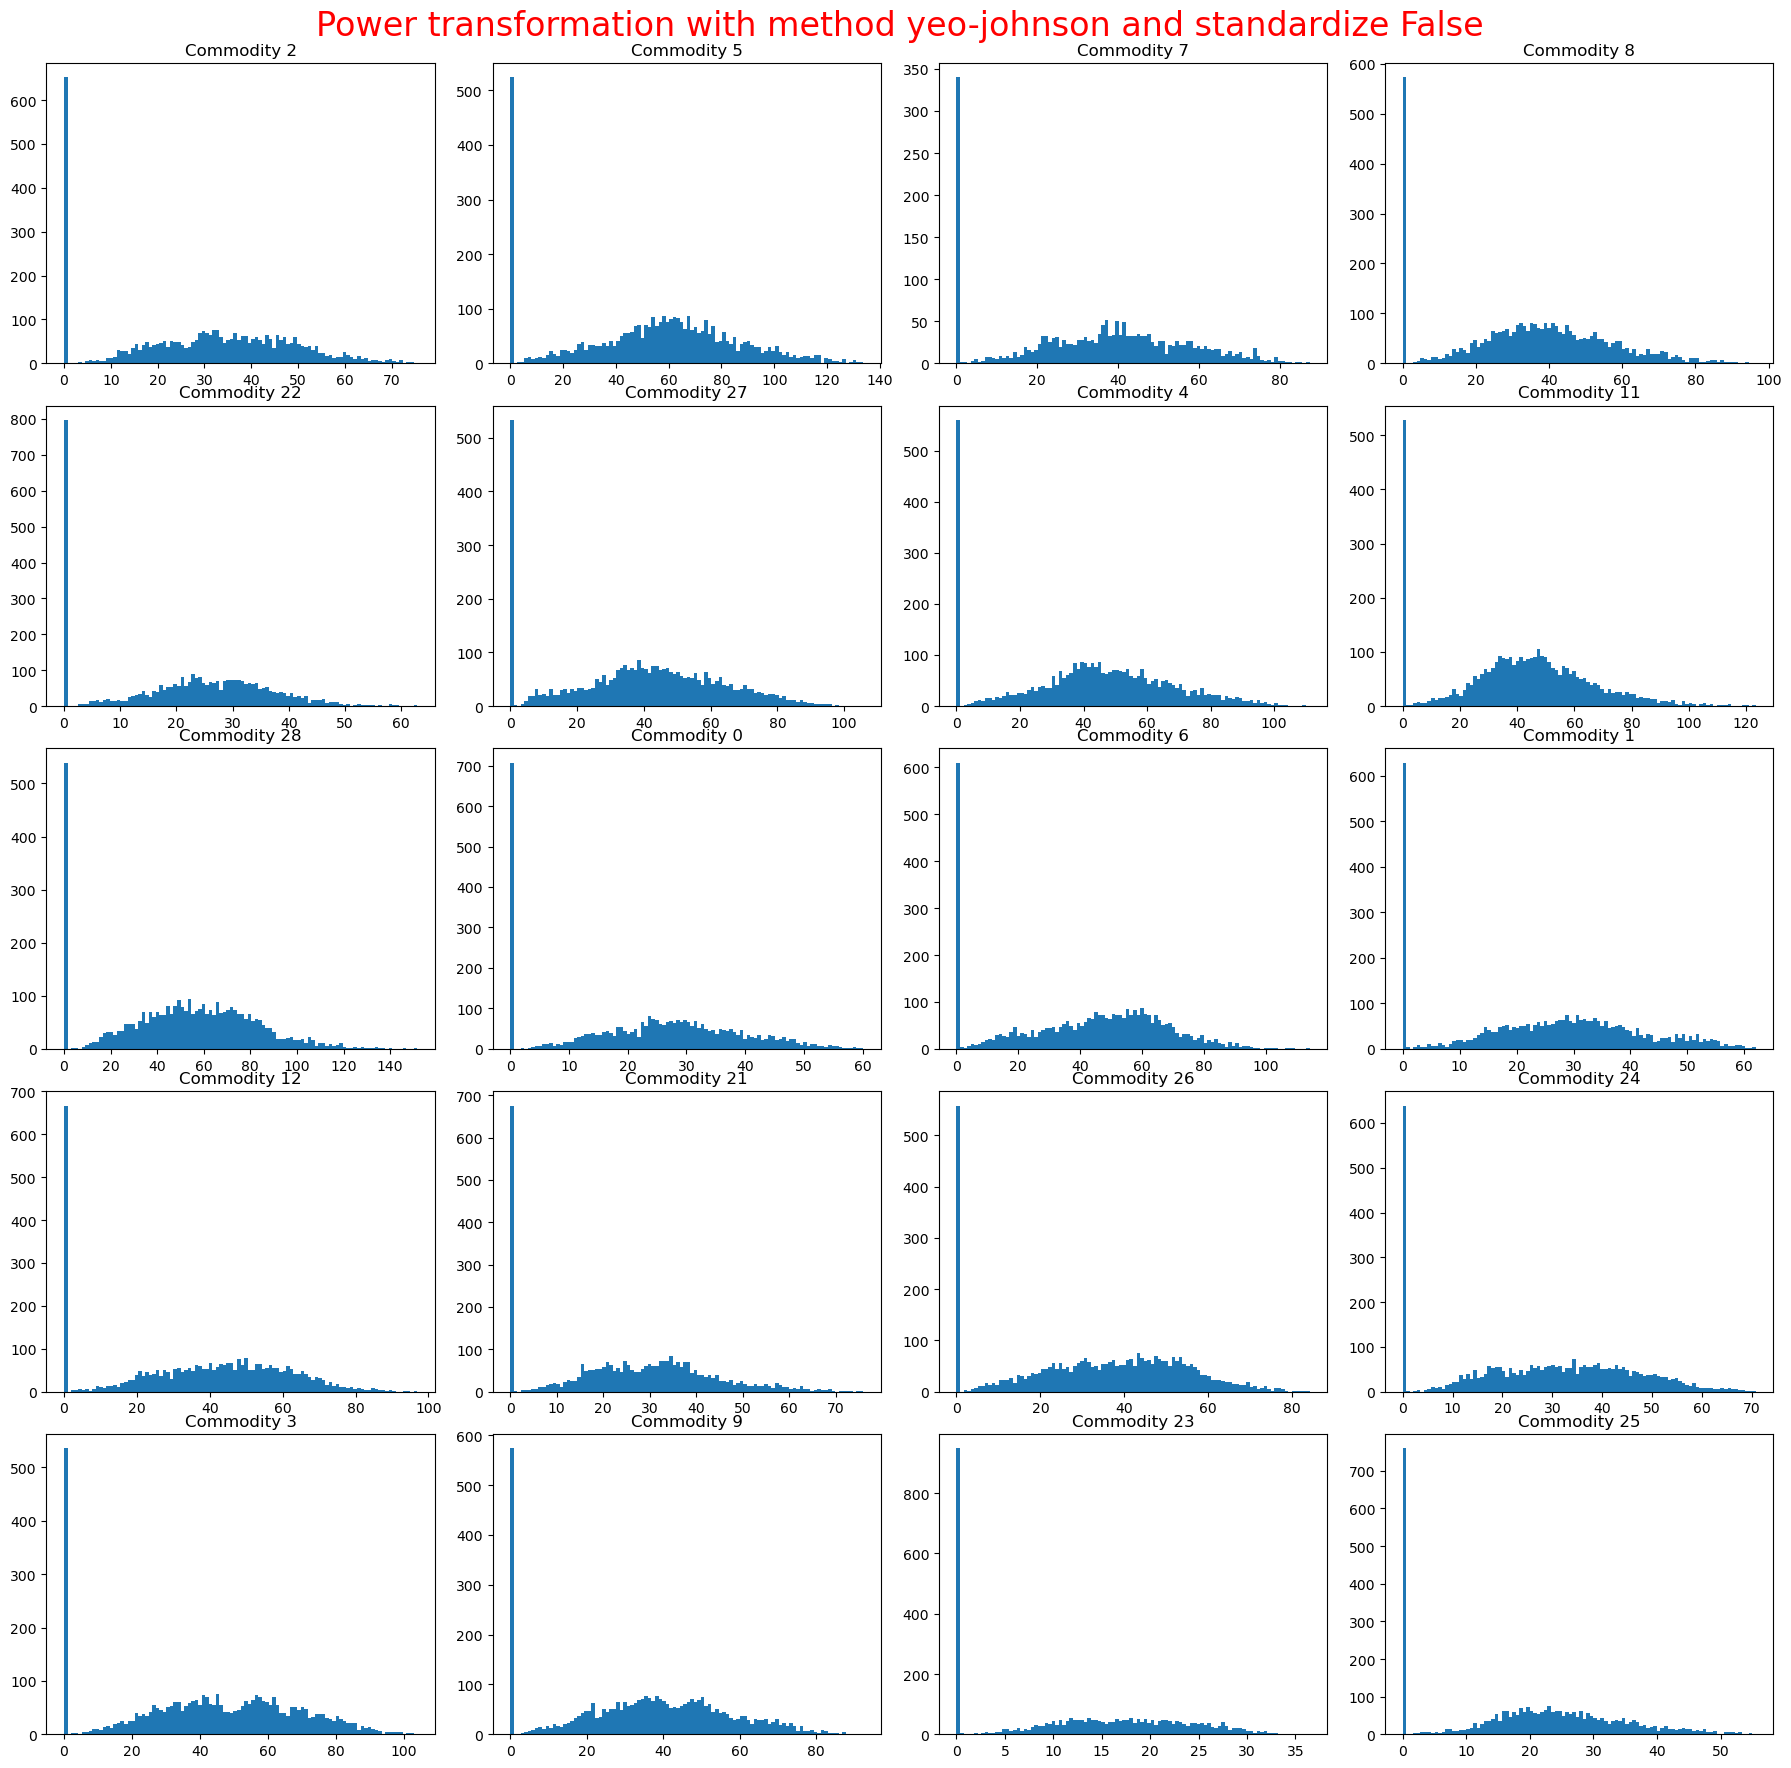

In [10]:
dfs_pt, title = transform(dfs, "PowerTransformer", method='yeo-johnson', standardize=False)
plot_all_commodity(dfs_pt, transformation=title)

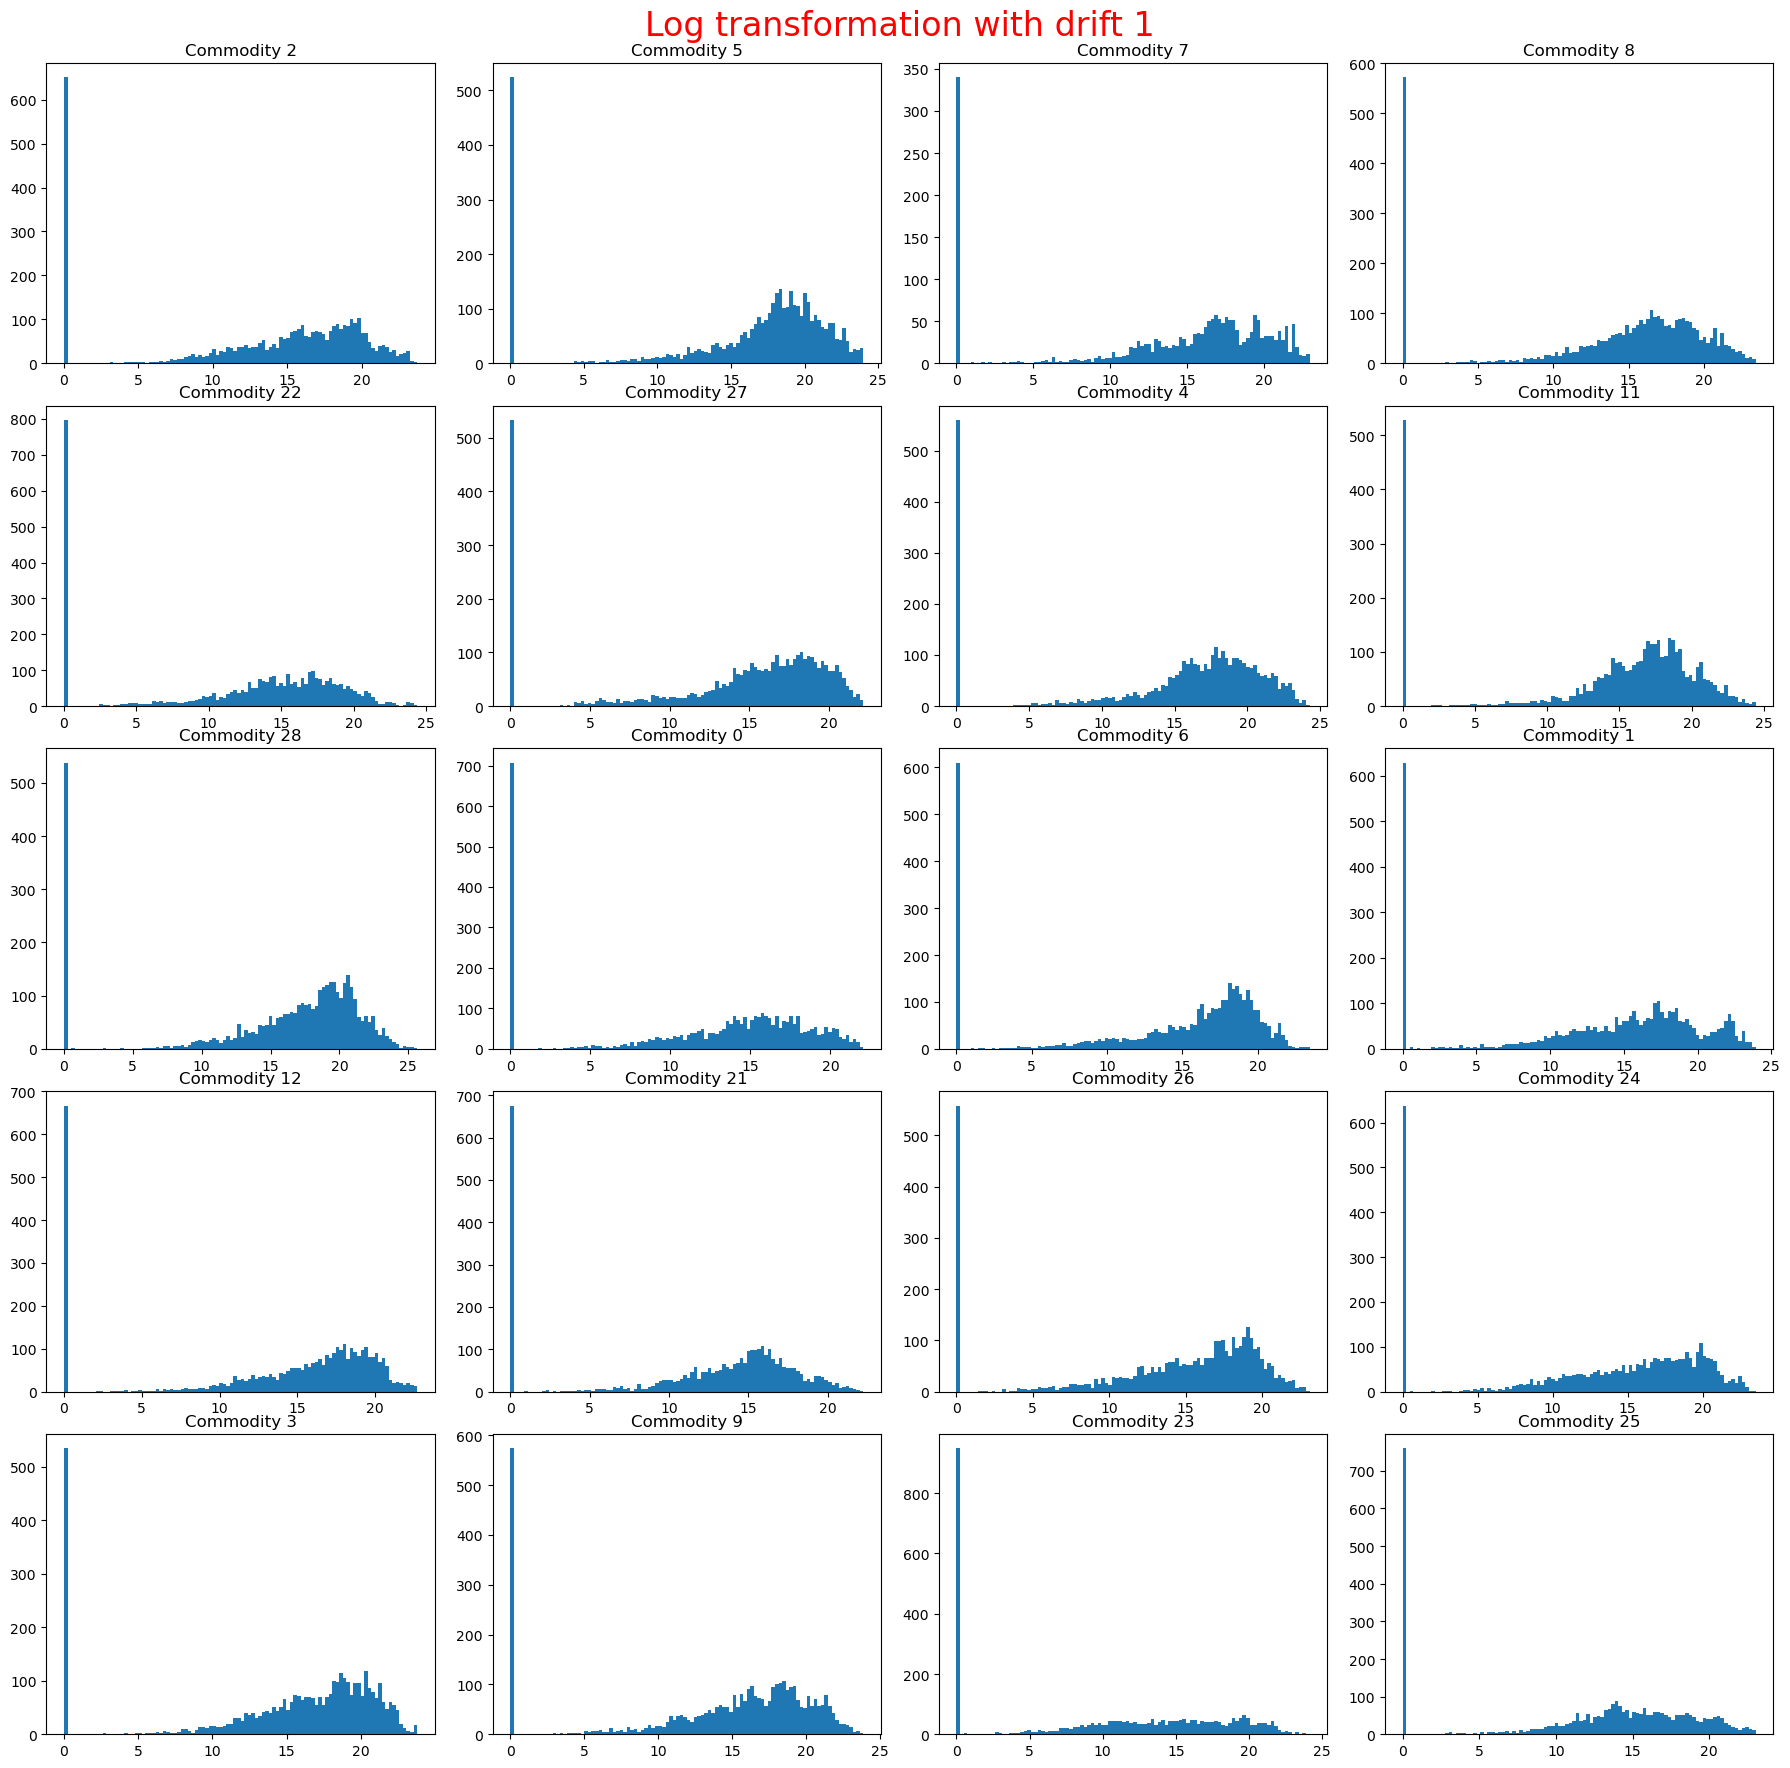

In [11]:
dfs_log, title = transform(dfs, "Log", e=1)
plot_all_commodity(dfs_log, transformation=title)

#### Each transformation plot

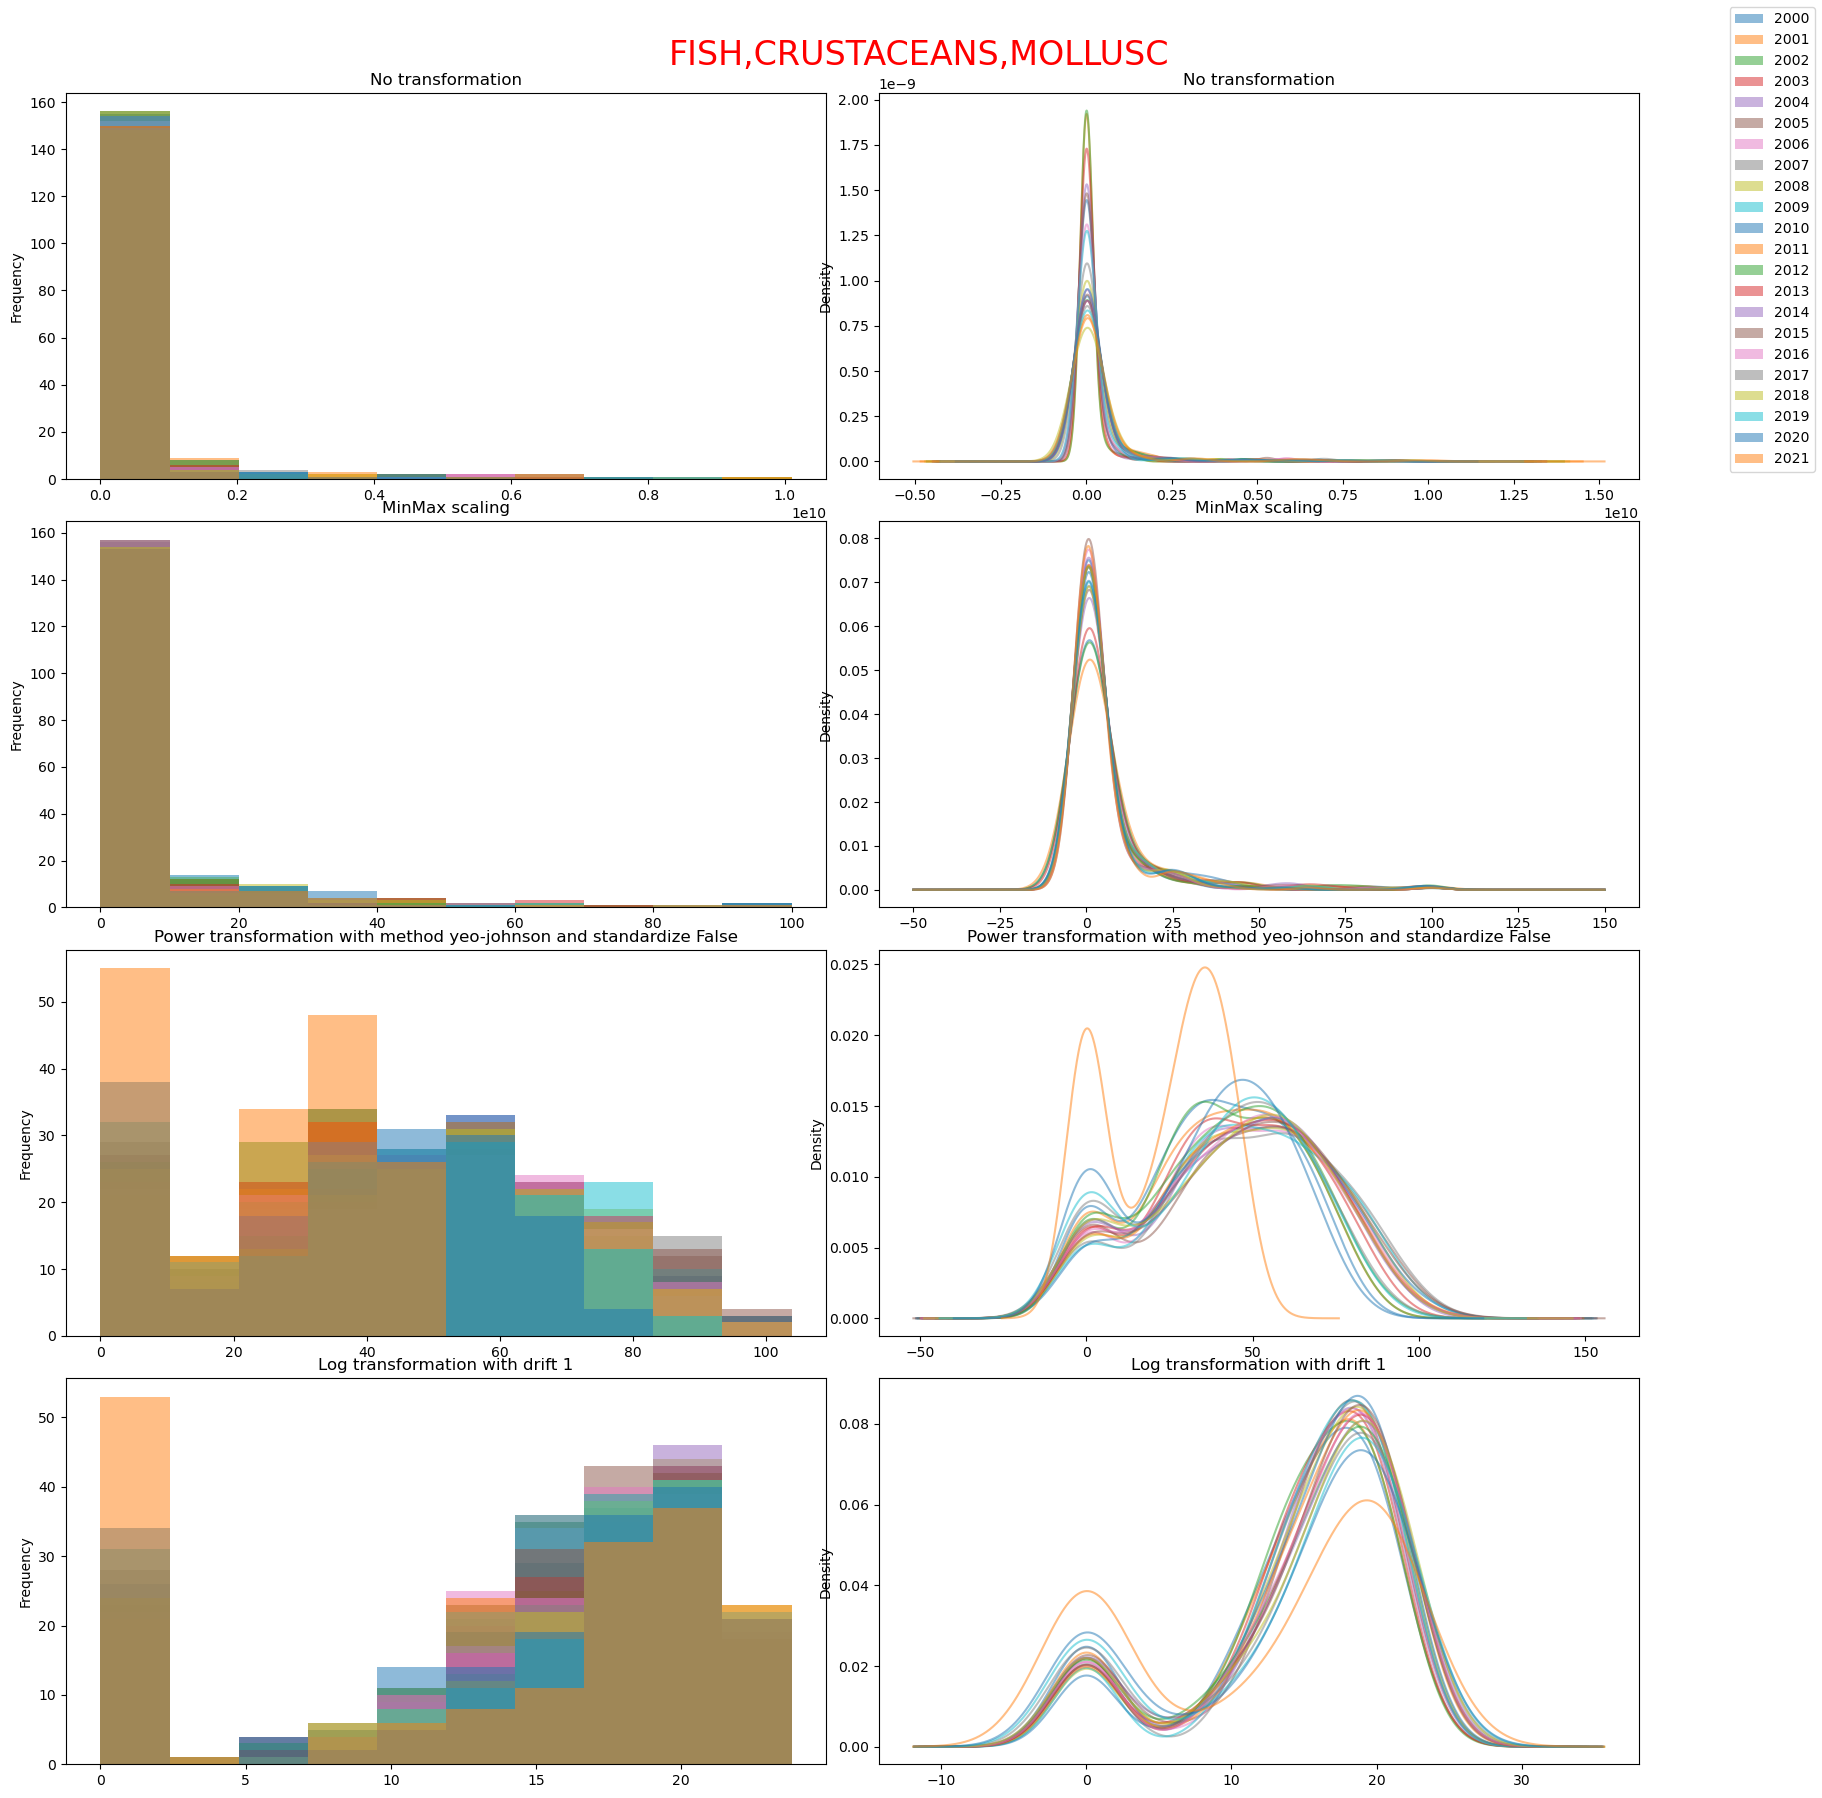

In [12]:
plot_one_commodity_with_transformation(dfs, 3)

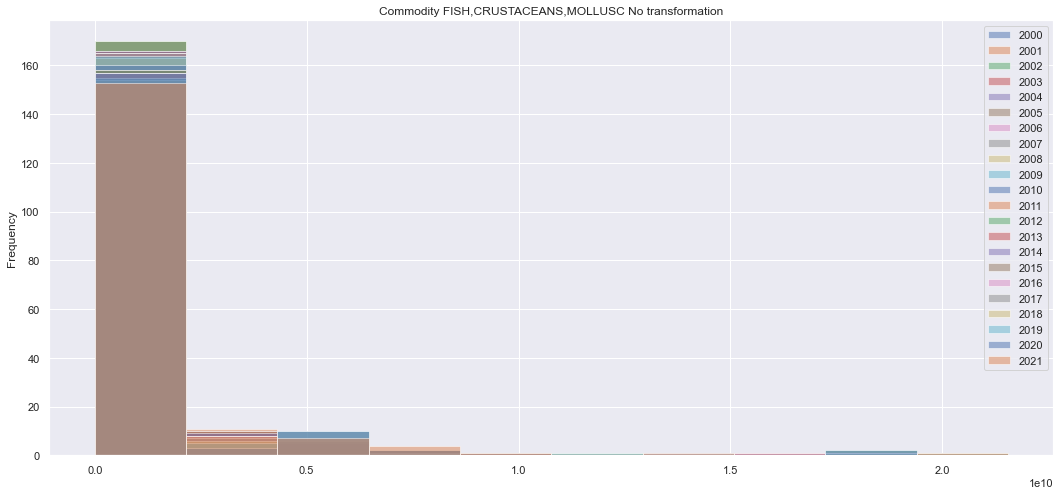

In [88]:
plot_one_commodity(dfs, 3, "No transformation", "hist")

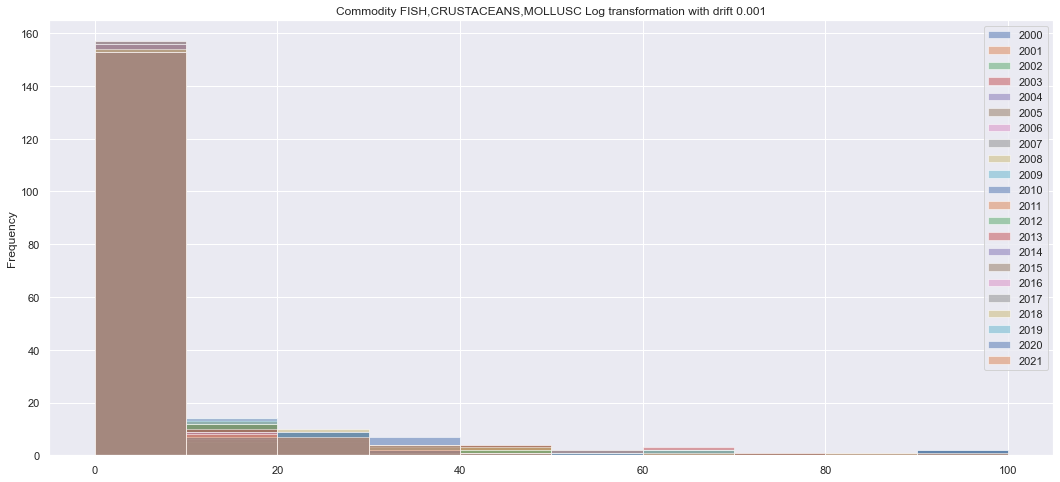

In [57]:
plot_one_commodity(dfs_log, 3, "Log transformation with drift {}".format(e), "hist")

### Clustering

In [13]:
# split df into two parts
p1 = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]
p2 = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

def split_df(df_dict, p1=p1, p2=p2, add_sum=False):
    dfs1, dfs2 = dict(), dict()
    for k, df in df_dict.items():
        dfs1[k] = df[p1]
        dfs2[k] = df[p2]

    if add_sum:
        for k, df in dfs1.items():
            dfs1[k]['Total'] = df.sum(axis=1)
        for k, df in dfs2.items():
            dfs2[k]['Total'] = df.sum(axis=1)

    return dfs1, dfs2

In [ ]:
# cant use raw data because of ill-defined empirical covariance

In [14]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.decomposition import PCA

In [18]:
def show_plot(df, comm, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
    if title:
        fig.suptitle(f"{title}: {commodities[comm]}", fontsize=18)
    else:
        fig.suptitle(commodities[comm], fontsize=18)

    fig.tight_layout()

    S, A, B = [], [], []
    K = range(2, 9)
    for k in K:
        model = GaussianMixture(n_components=k, random_state=42).fit(df)
        labels = model.predict(df)
        S.append(metrics.silhouette_score(df, labels, metric='euclidean'))
        B.append(model.bic(df))
        A.append(model.aic(df))

    ax1.plot(K, S, 'bo-', color='black')
    ax1.set_xlabel('n_components')
    ax1.set_ylabel('Silhouette Score')

    ax2.plot(K, B, 'bo-', label='BIC', color='blue')
    ax2.plot(K, A, 'bo-', label='AIC', color='red')
    ax2.legend(loc='best')
    ax2.set_xlabel('n_components')

    plt.show()

In [16]:
# dfs1_t, dfs2_t = split_df(dfs_t, transpose=True, add_sum=False)
dfs1_mm, dfs2_mm = split_df(dfs_mm, transpose=True, add_sum=False)
dfs1_pt, dfs2_pt = split_df(dfs_pt, transpose=True, add_sum=False)
dfs1_log, dfs2_log = split_df(dfs_log, transpose=True, add_sum=False)

TypeError: split_df() got an unexpected keyword argument 'transpose'

In [17]:
show_plot(dfs1_log[3].copy(), 3, "(power transform) 2000 to 2008")

NameError: name 'dfs1_log' is not defined

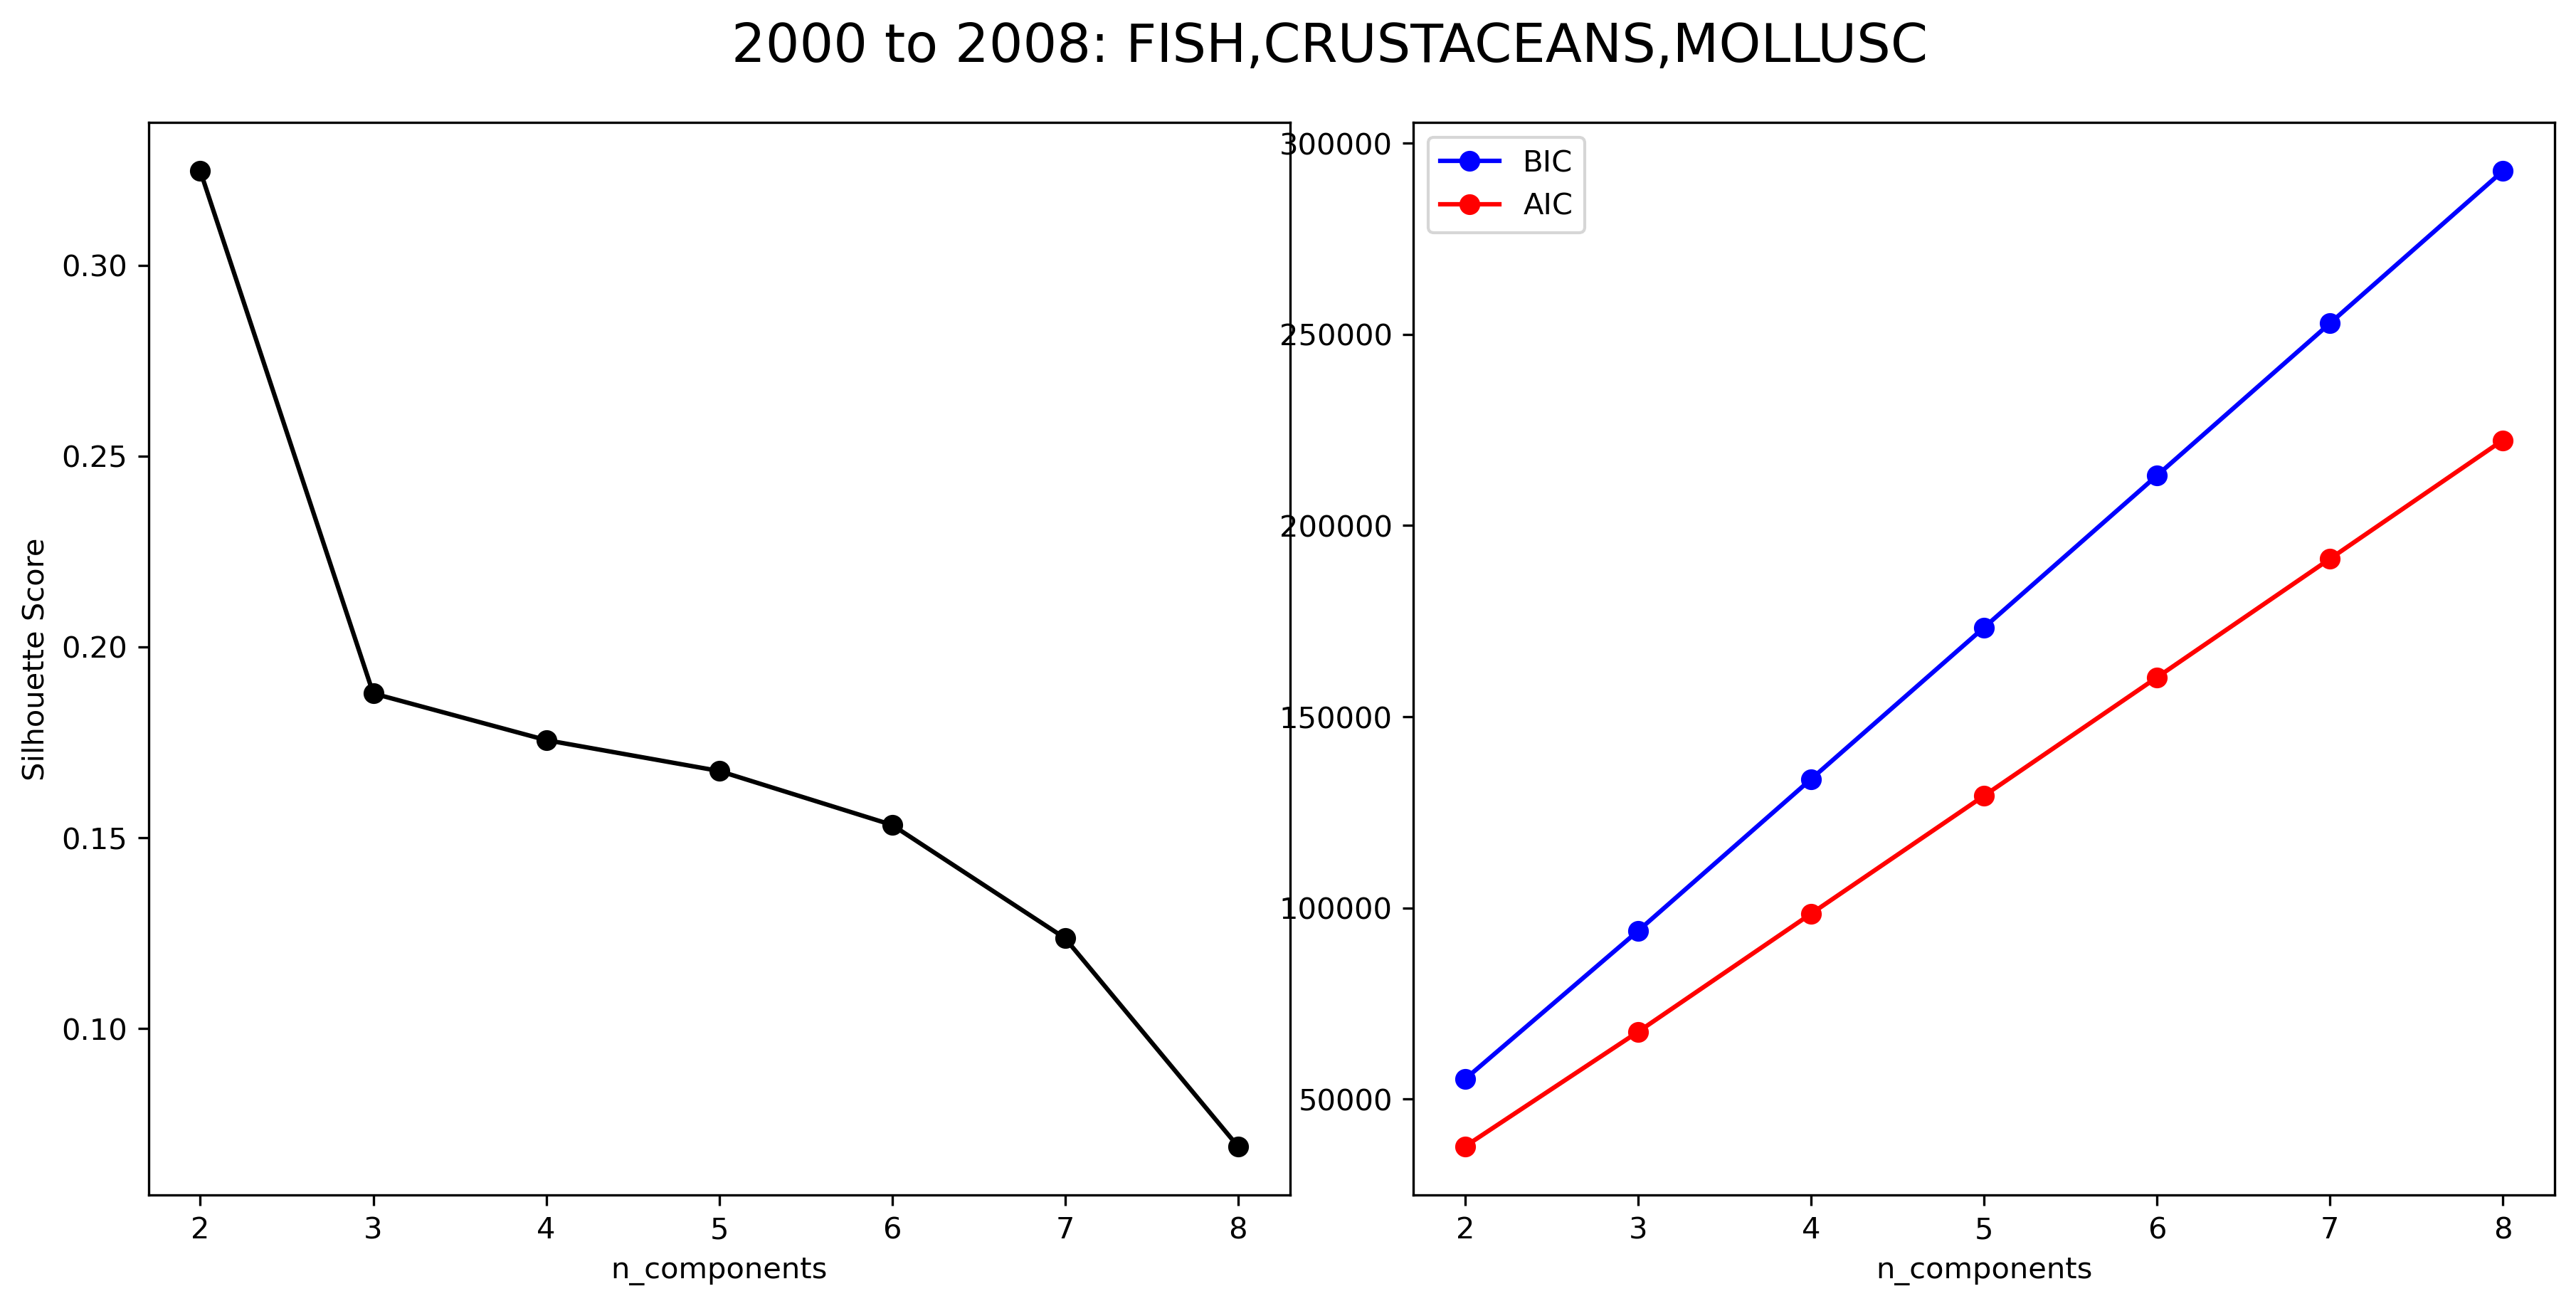

In [51]:
show_plot(dfs2_log[3].copy(), 3, "2000 to 2008")

In [34]:
n = 3
df = dfs1_log[3].copy()
model1 = GaussianMixture(n_components=n).fit(df)
labels2 = model.predict(df)

In [ ]:
n = 3
df = dfs2_log[3].copy()
model2 = GaussianMixture(n_components=n).fit(df)
labels2 = model.predict(df)

In [76]:
import itertools
color_iter = itertools.cycle(["navy", "c", "cornflowerblue"])
from scipy import linalg
import matplotlib as mpl

In [95]:
# from sklearn docs
def plot_results(X, Y_, means, covariances, title):
    plt.figure(figsize=(18, 18))
    splot = plt.subplot(1, 1, 1)
    splot.set_facecolor("white")
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1])

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.8)
        splot.add_artist(ell)

    plt.title(title)

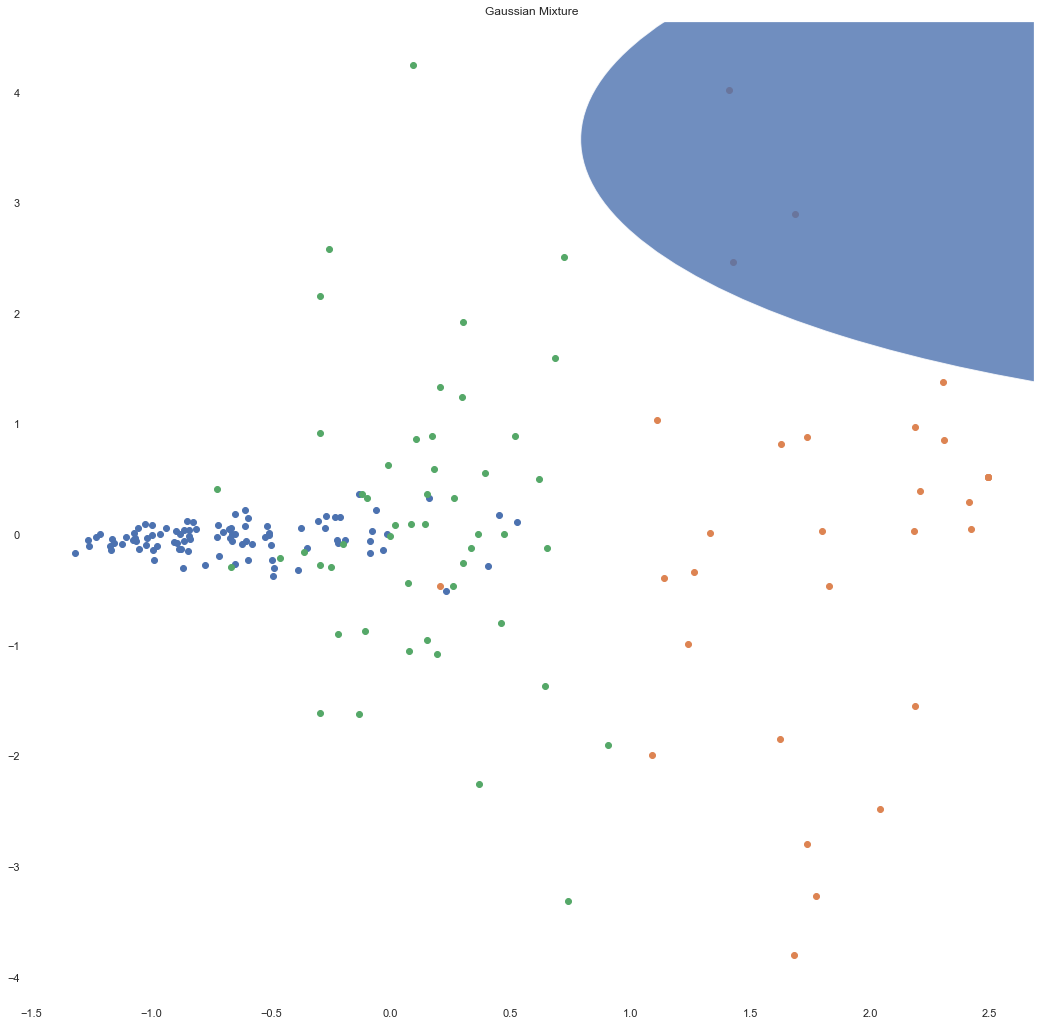

In [96]:
plot_results(data, labels, model.means_, model.covariances_, 'Gaussian Mixture')

In [ ]:
metrics = {
    'silhouette': metrics.silhouette_score(df, labels, metric='euclidean'),
    'bic': model.bic(df),
    'aic': model.aic(df),
    
}

In [106]:
print(  
    f"aic: {model.aic(df)}", 
    f"bic: {model.bic(df)}", 
    f"silhouette_score: {metrics.silhouette_score(df, labels, metric='euclidean')}", 
    f"Converged: {model.converged_}"
    , sep='\n')

aic: 4825.946128605292
bic: 5344.971028328749
silhouette_score: 0.3584567116377534
Converged: True


In [33]:
# minmaxscaling
# reducing the data in 1 dimension retians 99% of the variance
# using pca with 2 components
# retains almost all the variance and is easier to visualize

# without minmaxscaling
# keeps the variance scatter pca to 2 components reduces variance to about 90%

In [105]:
model.converged_

True

In [69]:
unique_elements, counts_elements = np.unique(labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[ 0  1  2]
 [94 31 50]]


In [104]:
pca = PCA(2, whiten=True)
data = pca.fit_transform(dfs1_log[3].copy())
print(f"Shape: {data.shape}")
print(f"Explained variance: {pca.explained_variance_ratio_.cumsum()[-1]*100.0:.2f}%")

Shape: (175, 2)
Explained variance: 87.82%


In [97]:
pca_df = pd.DataFrame(data, columns=[f"PC{i}" for i in range(1, data.shape[1]+1)])
pca_df["labels"] = labels
pca_df.head()

,PC1,PC2,labels
0,-0.248439,-0.290126,2
1,-0.191777,-0.046545,0
2,2.182694,0.033199,1
3,2.186549,-1.549339,1
4,2.209326,0.396261,1


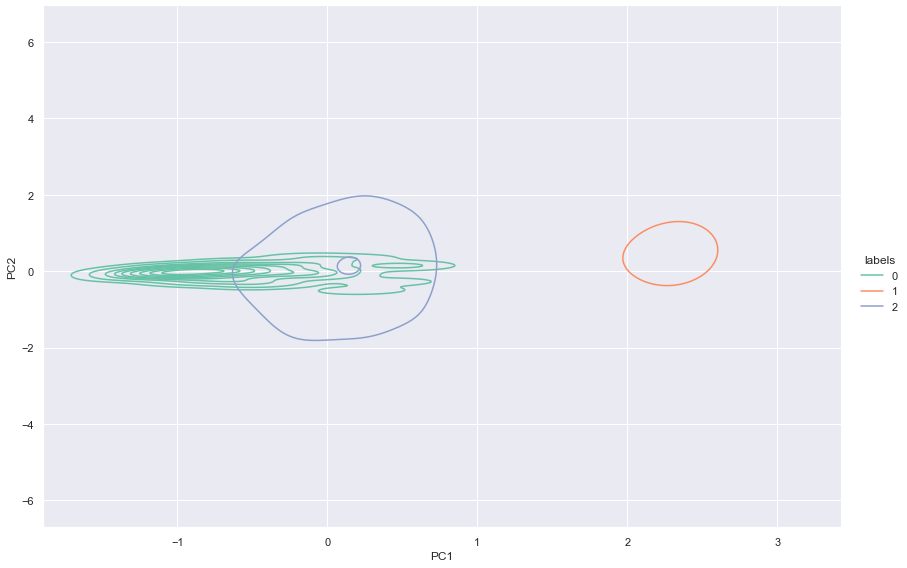

In [98]:
sns.displot(data=pca_df, x="PC1", y="PC2", kind="kde", hue='labels', palette='Set2', height=8, aspect=1.5)
plt.show()